# Simple pendulum

In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


# Tracking from Pendulum video footage 

### Finding the reference point (hook of pendulum)

In [1]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 3
video_path = "pendulum_101_ref.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


HSV Color at (2218, 53): [120 255 242]
HSV Color at (2142, 45): [120 255 242]
HSV Color at (2113, 45): [120 255 242]
HSV Color at (2106, 66): [122 246 242]
HSV Color at (2127, 138): [123 105 250]
HSV Color at (2232, 145): [122 106 244]
HSV Color at (2235, 53): [120 255 242]
HSV Color at (2143, 63): [121 255 245]
HSV Color at (2115, 84): [  0   0 252]


In [ ]:
# center = (943.5, 711.5)
center = (1237, 38)
color = [120, 255, 243]
[ 17, 139,  88]
[ 16, 167,  81]
[ 18 138  96]

### Tracking the pendulum

In [1]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
color_delta = 10
lower_color = np.array([120, 105, 240])-color_delta  
upper_color = np.array([123, 255, 250])+color_delta

for ind in [101]:
    # ind =1
    video_path = "pendulum_{}.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time
    positions = []
    frame_count = 0  # To track frame number

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Select the largest contour (assumed to be the pendulum bob)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box around the detected bob
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate center of the bounding box (Pendulum bob's position)
            center_x = x + w // 2
            center_y = y + h // 2

            # Store time and coordinates
            positions.append([time, center_x, center_y])

            # Draw tracking marker
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X", "Y"])
    df.to_csv("pendulum_yt_{}.csv".format(ind), index=False)

    print("Pendulum position data with time saved to 'pendulum_time_series.csv'")


Pendulum position data with time saved to 'pendulum_time_series.csv'


## Loading data

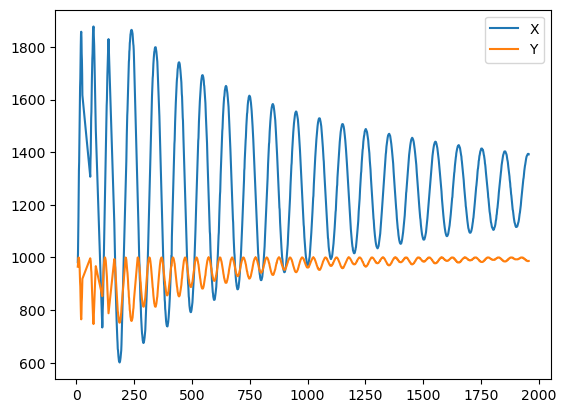

In [10]:

# Loading pendulum data
df_list = []
for ind in [101]:
    file_path = f"pendulum_yt_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(50,1400), (50,1200), (400,1400)]
# trimming_slices=  [(10,700), (10,700), (10,700), (10,700), (10,700)]
trimming_slices = [(10,-10)]

df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))


y_mean = df_trimmed[0]["Y"].mean()
y_std = df_trimmed[0]["Y"].std()
filtered_indices = abs(df_trimmed[0]["Y"] - y_mean) < 2 * y_std

df_trimmed[0] = df_trimmed[0][filtered_indices].reset_index(drop=True)
# Plot the filtered data
df_trimmed[0].loc[filtered_indices, ["X", "Y"]].plot()

#centering the hook of pendulum to origin
center = (1237, 38)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x"] = df_["X"] - center[0]
    df_["y"] = df_["Y"] - center[1]

for i, df in enumerate(df_trimmed):
    df.to_csv(f"pendulum_yt_{i+1}.csv", index=False)

<Axes: >

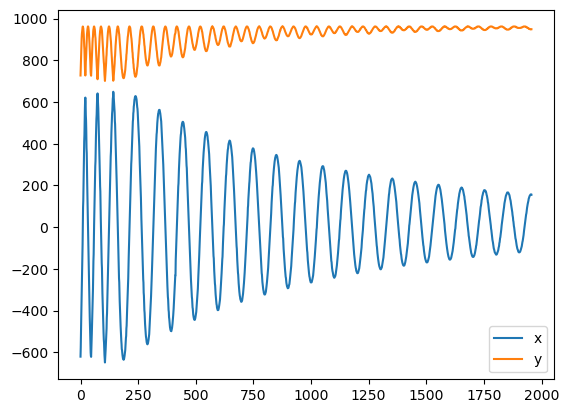

In [11]:
df_trimmed[0][["x","y"]].plot()

In [12]:
L=1    
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y"].max())
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)




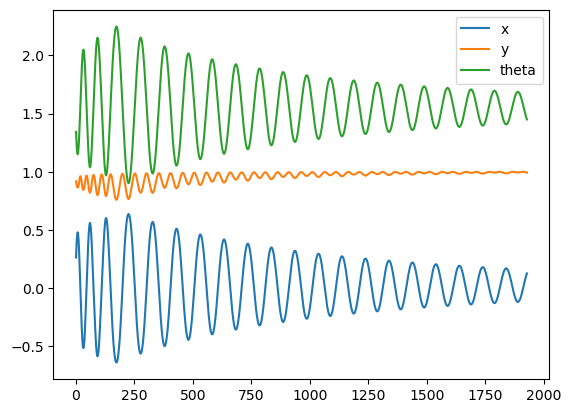

In [13]:
for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()

In [14]:
df_appended = pd.concat(df_trimmed, ignore_index=True)

In [15]:
(df_appended["x"]**2+df_appended["y"]**2).mean()
(df_appended["x"]**2+df_appended["y"]**2).std()


0.012881869271254419

<Axes: >

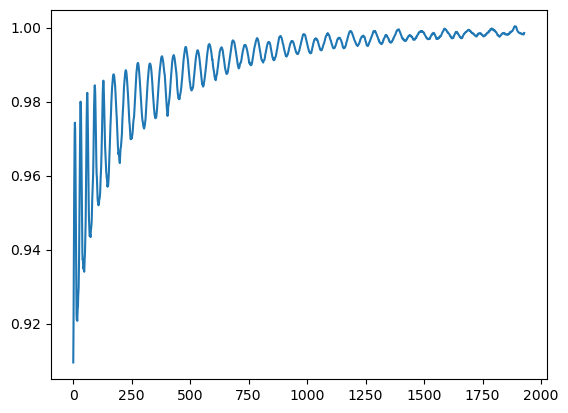

In [16]:
(df_appended["x"]**2+df_appended["y"]**2).plot()

In [14]:
data_amplify_fact = 1

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[100:-100]
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

In [29]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 3
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2',
       'theta^3', 'theta^2 theta_dot', 'theta theta_dot^2', 'theta_dot^3'],
      dtype='object')


In [30]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])
candidate_lib_full["x"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["y"] = data_matrix_df_smooth_appended["y"]

# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


<Axes: >

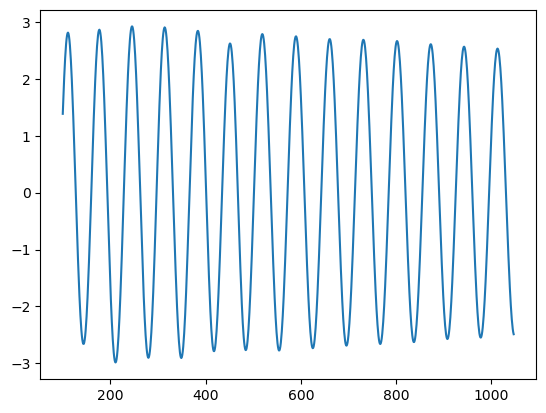

In [31]:
data_matrix_smooth_df_list[0]['d^2(theta) /dt^2'].plot()

In [32]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with mean=False to keep the mean the same
scaler = StandardScaler(with_std=False, with_mean=False)

# Scale candidate_lib_full
candidate_lib_full_scaled = pd.DataFrame(scaler.fit_transform(candidate_lib_full), columns=candidate_lib_full.columns)

# Scale data_matrix_df_smooth_appended
data_matrix_df_smooth_appended_scaled = pd.DataFrame(scaler.fit_transform(data_matrix_df_smooth_appended), columns=data_matrix_df_smooth_appended.columns)



In [33]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.002, coef_threshold= 0.05)
# seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.001, coef_threshold= 0.01)

# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 10
X_downsampled = candidate_lib_full_scaled.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.298e-02, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.377e-02, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to 

0.9920438661878009

In [34]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'theta': 0.0,
 'theta_dot': 0.0,
 'theta^2': -1.3649049455939446,
 'theta theta_dot': 0.0,
 'theta_dot^2': 0.0,
 'theta^3': -1.6082132236043578,
 'theta^2 theta_dot': 0.0,
 'theta theta_dot^2': -0.6817413258744885,
 'theta_dot^3': 0.0,
 'x': 0.0,
 'y': 0.0}

In [27]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["x", "theta", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["x","theta", "theta_dot"]], y=y_downsampled)

0.9991556358568099

In [28]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x': 157.0665488987067,
 'theta': 150.99621318587606,
 'theta_dot': 0.011681640765616301}

In [23]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)

0.9945111308005572